# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

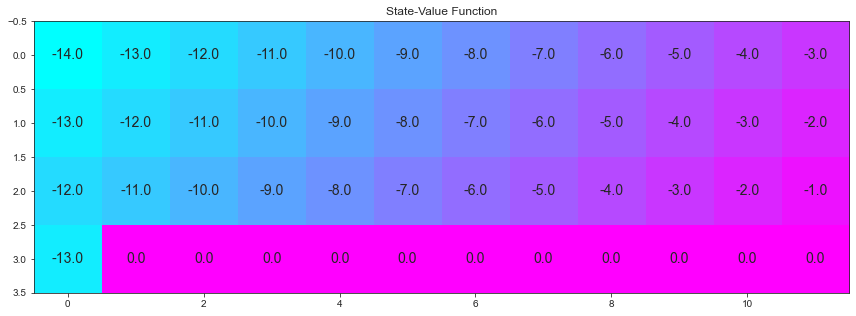

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

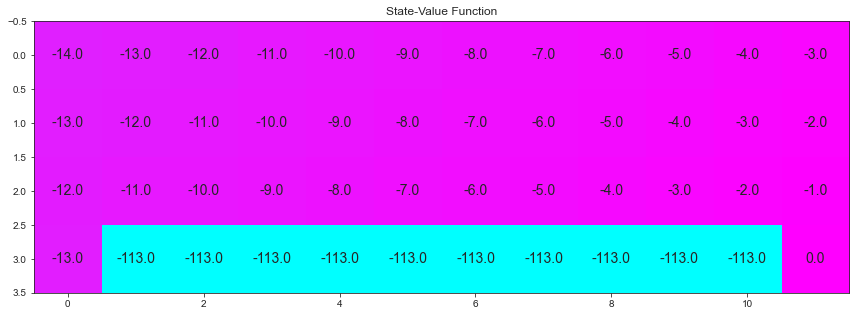

In [5]:
# The above code is buggy but np indexing is too magic here and hides it. 
# I think it should be like this:
V_opt = np.zeros((4,12))
V_opt[0][0:12] = -np.arange(1, 13)[::-1] - 2
V_opt[1][0:12] = -np.arange(1, 13)[::-1] - 1
V_opt[2][0:12] = -np.arange(1, 13)[::-1]
V_opt[3][0] = -13

# also I think that the last row should be like this:
V_opt[3][1:11] = -113

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

### Sarsa: Pseudocode of implementation

<img src="images/Sarsa.png" alt="Pseudocode of implementation" width="500"/>

In [135]:
def get_epsilon_greedy_action(env, Q, state, epsilon):
    """This chooses an action using the epsilon-greedy policy"""
    if state not in Q or np.random.random() < epsilon:
        action = np.random.choice(np.arange(env.nA))  # Random action
    else:
        action = np.argmax(Q[state])  # Greedy (best) action
    return action

In [136]:
def generate_episode_from_limit_e_greedy(env, Q, epsilon, gamma, alpha, max_steps=None):
    """max_steps is used to limite the maximum allowed lengh of an episode. 
    This is key in order to get a reasonably fast convergence. Without it, even with 
    100000 episodes the policy does not converge to the optimmal one. I believe that the
    limit helps by ensuring that the values of the Q table don't go too negative in the
    first episodes for the row that goes along the cliff. If we allow them to become too
    negative, it takes a great number of episodes (and a hard to tweak value for alpha and
    epsilon) to recover from this.
    """
    episode_return = 0
    done = False
    num_steps = 0
    
    state = env.reset()
    action = get_epsilon_greedy_action(env, Q, state, epsilon)

    while not done:
        
        next_state, reward, done, info = env.step(action)
        episode_return += reward
        next_action = get_epsilon_greedy_action(env, Q, next_state, epsilon)
        
        # The next line is the only thing that changes between SARSA, Q-Learning (SARSAmax) and Expected SARSA
        _return = reward + gamma * Q[next_state][next_action]
        Q[state][action] += alpha * (_return - Q[state][action])

        state = next_state        
        action = next_action
        
        num_steps += 1
        if max_steps is not None and num_steps >= max_steps:
            break
    
    return episode_return

In [140]:
def plot_performance(num_episodes, return_averages, window_size):

    plt.plot(np.linspace(0, num_episodes, len(return_averages), endpoint=False), np.asarray(return_averages))
    plt.xlabel("Episode Number")
    plt.ylabel(f"Average Reward (Over Next {window_size} Episodes)")
    plt.show()
    # print best 100-episode performance
    print(f"Best Average Reward over {window_size} Episodes: {np.max(return_averages)}")

In [211]:
def sarsa(env, num_episodes=5000, alpha=0.01, gamma=1.0, initial_Q=None, max_steps=300, 
          eps_decay_method='inverse', eps_start=1.0, eps_decay=.99998961, eps_min=0.0001):
    
    MONITORING_STEPS = 100
    returns_window = deque(maxlen=MONITORING_STEPS)
    return_averages =[]
    
    num_actions = env.action_space.n
    # initialize empty dictionary of arrays
    Q = initial_Q if initial_Q is not None else defaultdict(lambda: np.zeros(num_actions))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        ## TODO: complete the function
        episode_return = generate_episode_from_limit_e_greedy(env, Q, epsilon, gamma, alpha, max_steps)
        returns_window.append(episode_return)
        
        if eps_decay_method == 'exponential':
            # For this to converge, we need these parameters:
            # num_episodes=1000000, alpha=0.01, gamma=1.0, initial_Q=None, max_steps=300, 
            # eps_start=1.0, eps_decay=.99999, eps_min=0.0001
            epsilon = max(eps_decay * epsilon, eps_min)

        elif eps_decay_method == 'inverse':
            # This is, by far, the epsilon decay function that converges the fastest
            # It is enough to run with these parameters:
            # num_episodes=5000, alpha=0.01, gamma=1.0, initial_Q=None, max_steps=300, eps_start=1.0
            epsilon = eps_start / i_episode
        
        else:
            raise ValueError(f"eps_decay_method = '{eps_decay_method}' is not supported")
        
        if (i_episode % MONITORING_STEPS == 0):
            return_averages.append(np.mean(returns_window))
            
            print("\rEpisode {}/{}. epsilon={:1.12f}, 100 last returns average {:3.2f}".format(
                i_episode, num_episodes, epsilon, return_averages[-1]), end="")
            sys.stdout.flush()
    
    plot_performance(num_episodes, return_averages, MONITORING_STEPS)
    print(f"\nLast value of {epsilon=:1.12f}")
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000. epsilon=0.000200000000, 100 last returns average -13.00

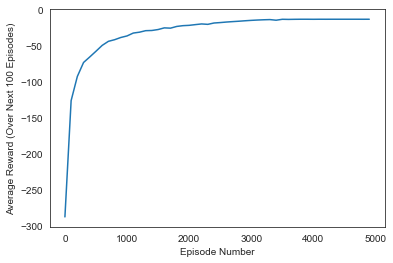

Best Average Reward over 100 Episodes: -13.0

Last value of epsilon=0.000200000000


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  0  2  1  1  1  2  1  1  3  2  2]
 [ 0  1  2  0  0  1  1  0  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


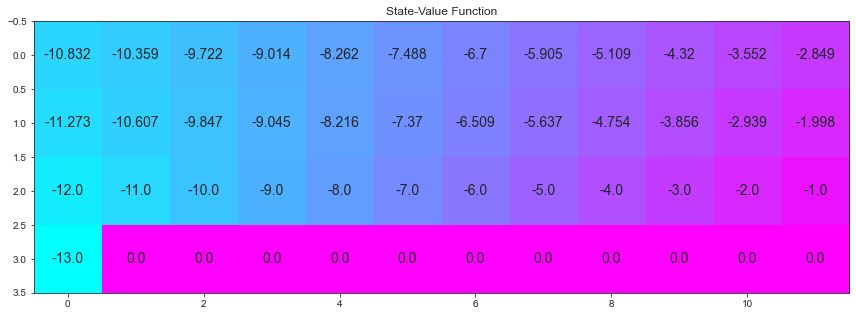

In [213]:
# obtain the estimated optimal policy and corresponding action-value function
# Fast convergence; seems to work every time:
Q_sarsa = sarsa(env, num_episodes=5000, eps_decay_method='inverse')


# Starting with epsilon = 1 and using a slow decay I did not manage to have it converging
#Q_sarsa = sarsa(env, num_episodes=700000, alpha=0.01, gamma=1.0, initial_Q=None, max_steps=300, 
#                eps_decay_method='exponential', eps_start=1.0, eps_decay=.99998026, eps_min=0.0001)

# Smaller start values of epsilon work better
#Q_sarsa = sarsa(env, num_episodes=5000, alpha=0.01, gamma=1.0, initial_Q=None, max_steps=300, 
#                eps_decay_method='exponential', eps_start=0.001, eps_decay=.9999, eps_min=0.0001)

# Or faster decays. In that case, we can even remove the eps_min (set it to 0.0):
#Q_sarsa = sarsa(env, num_episodes=5000, alpha=0.01, gamma=1.0, initial_Q=None, max_steps=300, 
#                eps_decay_method='exponential', eps_start=1.0, eps_decay=.98, eps_min=0.0001)


# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

### Sarsamax / Q-Learning: Pseudocode of implementation

<img src="images/Sarsamax Q-Learning.png" alt="Pseudocode of implementation" width="500"/>

In [222]:
def generate_episode_for_q_learning(env, Q, epsilon, gamma, alpha, max_steps=None):
    """max_steps is used to limite the maximum allowed lengh of an episode. 
    This is key in order to get a reasonably fast convergence. Without it, even with 
    100000 episodes the policy does not converge to the optimmal one. I believe that the
    limit helps by ensuring that the values of the Q table don't go too negative in the
    first episodes for the row that goes along the cliff. If we allow them to become too
    negative, it takes a great number of episodes (and a hard to tweak value for alpha and
    epsilon) to recover from this.
    """
    episode_return = 0
    done = False
    num_steps = 0
    
    state = env.reset()
    action = get_epsilon_greedy_action(env, Q, state, epsilon)

    while not done:
        
        next_state, reward, done, info = env.step(action)
        episode_return += reward
        next_action = get_epsilon_greedy_action(env, Q, next_state, epsilon)
        
        # The next line is the only thing that changes between SARSA, Q-Learning (SARSAmax) and Expected SARSA
        _return = reward + gamma * max(Q[next_state])
        Q[state][action] += alpha * (_return - Q[state][action])

        state = next_state        
        action = next_action
        
        num_steps += 1
        if max_steps is not None and num_steps >= max_steps:
            break
    
    return episode_return

In [223]:
def q_learning(env, num_episodes=5000, alpha=0.01, gamma=1.0, initial_Q=None, max_steps=300, 
               eps_decay_method='inverse', eps_start=1.0, eps_decay=.99998961, eps_min=0.0001):
    
    MONITORING_STEPS = 100
    returns_window = deque(maxlen=MONITORING_STEPS)
    return_averages =[]
    
    num_actions = env.action_space.n
    # initialize empty dictionary of arrays
    Q = initial_Q if initial_Q is not None else defaultdict(lambda: np.zeros(num_actions))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        ## TODO: complete the function
        episode_return = generate_episode_for_q_learning(env, Q, epsilon, gamma, alpha, max_steps)
        returns_window.append(episode_return)
        
        if eps_decay_method == 'exponential':
            # For this to converge, we need these parameters:
            # num_episodes=1000000, alpha=0.01, gamma=1.0, initial_Q=None, max_steps=300, 
            # eps_start=1.0, eps_decay=.99999, eps_min=0.0001
            epsilon = max(eps_decay * epsilon, eps_min)

        elif eps_decay_method == 'inverse':
            # This is, by far, the epsilon decay function that converges the fastest
            # It is enough to run with these parameters:
            # num_episodes=5000, alpha=0.01, gamma=1.0, initial_Q=None, max_steps=300, eps_start=1.0
            epsilon = eps_start / i_episode
        
        else:
            raise ValueError(f"eps_decay_method = '{eps_decay_method}' is not supported")
        
        if (i_episode % MONITORING_STEPS == 0):
            return_averages.append(np.mean(returns_window))
            
            print("\rEpisode {}/{}. epsilon={:1.12f}, 100 last returns average {:3.2f}".format(
                i_episode, num_episodes, epsilon, return_averages[-1]), end="")
            sys.stdout.flush()
    
    plot_performance(num_episodes, return_averages, MONITORING_STEPS)
    print(f"\nLast value of {epsilon=:1.12f}")
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000. epsilon=0.000200000000, 100 last returns average -13.00

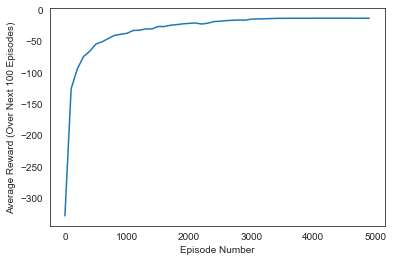

Best Average Reward over 100 Episodes: -13.0

Last value of epsilon=0.000200000000


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  1  3  1  1  1  1  1  1  1  3  2]
 [ 1  0  1  1  1  1  1  2  2  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


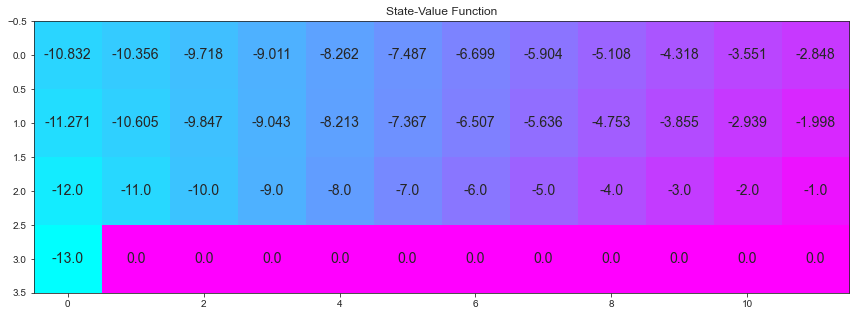

In [228]:
# obtain the estimated optimal policy and corresponding action-value function
# Fast convergence; seems to work every time:
#Q_sarsamax = q_learning(env, num_episodes=5000, eps_decay_method='inverse')

# This also works
#Q_sarsa = sarsa(env, num_episodes=5000, alpha=0.01, gamma=1.0, initial_Q=None, max_steps=300, 
#                eps_decay_method='exponential', eps_start=0.001, eps_decay=.9999, eps_min=0.0001)

# And this as well
#Q_sarsa = sarsa(env, num_episodes=5000, alpha=0.01, gamma=1.0, initial_Q=None, max_steps=300, 
#                eps_decay_method='exponential', eps_start=1.0, eps_decay=.98, eps_min=0.0001)



# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [ ]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])